# Chatbot with message summarization

## Review

We've covered how to customize graph state schema and reducer. 
 
We've also shown a number of ways to trim or filter messages in graph state. 

## Goals

Now, let's take it one step further! 

Rather than just trimming or filtering messages, we'll show how to use LLMs to produce a running summary of the conversation.
 
This allows us to retain a compressed representation of the full conversation, rather than just removing it with trimming or filtering.

We'll incorporate this summarization into a simple Chatbot.  

And we'll equip that Chatbot with memory, supporting long-running conversations without incurring high token cost / latency. 

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [ ]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

In [ ]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o",temperature=0)

We'll use `MessagesState`, as before.

In addition to the built-in `messages` key, we'll now include a custom key (`summary`).

In [ ]:
from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

We'll define a node to call our LLM that incorporates a summary, if it exists, into the prompt.

In [ ]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

We'll define a node to produce a summary.

Note, here we'll use `RemoveMessage` to filter our state after we've produced the summary.

In [ ]:
def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

We'll add a conditional edge to determine whether to produce a summary based on the conversation length.

In [ ]:
from langgraph.graph import END
# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

## Adding memory

Recall that [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

This limits our ability to have multi-turn conversations with interruptions. 

As introduced at the end of Module 1, we can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 
 
LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. 

As we previously showed, one of the easiest to work with is `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is compile the graph with a checkpointer, and our graph has memory!

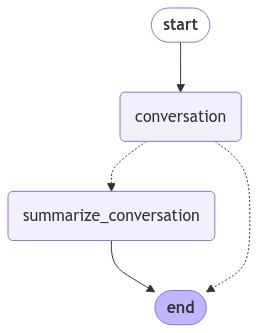

In [ ]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Threads

The checkpointer saves the state at each step as a checkpoint.

These saved checkpoints can be grouped into a `thread` of conversation.

Think about Slack as an analog: different channels carry different conversations.

Threads are like Slack channels, capturing grouped collections of state (e.g., conversation).

Below, we use `configurable` to set a thread ID.

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbadf3b379c2ee621adfd1_chatbot-summarization1.png)

In [ ]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hi Lance! How can I assist you today?
================================== Ai Message ==================================

You mentioned that your name is Lance. How can I help you today, Lance?
================================== Ai Message ==================================

That's awesome, Lance! The San Francisco 49ers have a rich history and a passionate fan base. Do you have a favorite player or a memorable game that stands out to you?


Now, we don't yet have a summary of the state because we still have < = 6 messages.

This was set in `should_continue`. 

```
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
```

We can pick up the conversation because we have the thread.

In [ ]:
graph.get_state(config).values.get("summary","")

''

The `config` with thread ID allows us to proceed from the previously logged state!

In [ ]:
input_message = HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Yes, Nick Bosa is indeed one of the highest-paid defensive players in the NFL. In September 2023, he signed a record-breaking contract extension with the San Francisco 49ers, making him the highest-paid defensive player at that time. His performance on the field has certainly earned him that recognition. It's great to hear you're a fan of such a talented player!


/var/folders/l9/bpjxdmfx7lvd1fbdjn38y5dh0000gn/T/ipykernel_18661/23381741.py:23: LangChainBetaWarning: The class `RemoveMessage` is in beta. It is actively being worked on, so the API may change.
  delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]


In [ ]:
graph.get_state(config).values.get("summary","")

"Lance introduced himself and mentioned that he is a fan of the San Francisco 49ers. He specifically likes Nick Bosa and inquired if Bosa is the highest-paid defensive player. I confirmed that Nick Bosa signed a record-breaking contract extension in September 2023, making him the highest-paid defensive player at that time, and acknowledged Bosa's talent and Lance's enthusiasm for the player."

----------------------------- Experiments -----------------------------------

In [1]:
from langgraph.graph import MessagesState
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, RemoveMessage
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

In [2]:
import os
from dotenv import load_dotenv

In [3]:
load_dotenv()
CHAT_LLAMA = os.getenv("CHAT_LLAMA")

In [4]:
model = ChatGroq(model=CHAT_LLAMA)

In [39]:
class State(MessagesState):
    """State maintainer for summary and messages"""
    summary: str

In [ ]:
def conversation(state:State):

    summary = state.get('summary')

    if summary:
        system_message = f"The following is the summary of our conversation so far: {summary}."
        messages = [SystemMessage(content=system_message)]+state['messages']
    else:
        messages = state['messages']

    output = model.invoke(messages)

    return ({'messages':output})

In [41]:
def summarization(state:State):
    
    summary = state.get('summary')

    if summary:
        new_summary = f"Here the summary of our conversation so far:{summary}, create a new summary using the new conversation messages above."
    else:
        new_summary = f"Create the summary of the above conversation"

    output = model.invoke(state['messages']+[HumanMessage(content=new_summary)])
    recent_messages = [RemoveMessage(id=m.id) for m in state['messages'][:-2]]

    return {'summary':output.content, 'messages':recent_messages}

In [42]:
def should_continue(state:State):
    """Returns the next node for execution."""
    messages = state['messages']
    if len(messages)>6:
        return "summarization"
    else:
        return END

In [43]:
memory = MemorySaver()
builder = StateGraph(State)

builder.add_node('conversation', conversation)
builder.add_node('summarization', summarization)

builder.add_edge(START,'conversation')
builder.add_conditional_edges('conversation',should_continue)
builder.add_edge('summarization',END)

graph = builder.compile(checkpointer=memory)

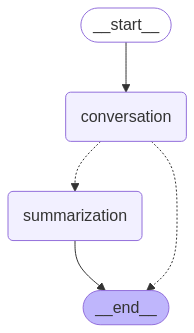

In [44]:
graph

In [45]:

# Start conversation
config={'configurable':{'thread_id':'thread1'}}
input_message = HumanMessage(content="hi! I'm Mark")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()



1
2
3
4
================================== Ai Message ==================================

Hello Mark! It's nice to meet you. Is there something I can help you with or would you like to chat?


In [46]:
input_message = HumanMessage(content="Im doing fine how about you?")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

1
2
3
4
================================== Ai Message ==================================

I'm just a language model, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to assist you with any questions or topics you'd like to discuss. How can I help you today, Mark?


In [47]:
input_message = HumanMessage(content="I like cricket")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

1
2
3
4
================================== Ai Message ==================================

Cricket is a fantastic sport. What aspect of cricket do you enjoy the most? Is it the thrill of watching a match, playing with friends, or following a particular team or player?


In [48]:
input_message = HumanMessage(content="I am a fan of Sachin Tendulkar")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

1
2
3
4
================================== Ai Message ==================================

A legendary choice! Sachin Tendulkar is widely regarded as one of the greatest batsmen in the history of cricket. His incredible career, records, and achievements have made him a household name. What is it about Sachin Tendulkar that you admire the most? Is it his incredible batting skills, his dedication to the sport, or his inspiring career milestones that you find most captivating?


In [49]:
input_message = HumanMessage(content="what do you know about me?")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

1
2
3
4
================================== Ai Message ==================================

Not much, actually! I'm just a conversational AI, and our conversation just started. You introduced yourself as a fan of Sachin Tendulkar, and I responded to that. I'm happy to chat with you and learn more about your interests. What would you like to talk about or ask?


In [50]:
output

{'messages': [HumanMessage(content='I am a fan of Sachin Tendulkar', additional_kwargs={}, response_metadata={}, id='0fcfab04-f261-460f-8c92-45be20d50100'),
  AIMessage(content='A legendary choice! Sachin Tendulkar is widely regarded as one of the greatest batsmen in the history of cricket. His incredible career, records, and achievements have made him a household name. What is it about Sachin Tendulkar that you admire the most? Is it his incredible batting skills, his dedication to the sport, or his inspiring career milestones that you find most captivating?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 171, 'total_tokens': 251, 'completion_time': 0.329929198, 'prompt_time': 0.015373767, 'queue_time': 0.04913044300000001, 'total_time': 0.345302965}, 'model_name': 'meta-llama/llama-4-maverick-17b-128e-instruct', 'system_fingerprint': 'fp_253f463456', 'finish_reason': 'stop', 'logprobs': None}, id='run-9e1d7bc9-243a-47f5-a706-f1438c

In [51]:
input_message = HumanMessage(content="Who is the prime minister of India?")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

1
2
3
4
================================== Ai Message ==================================

The current Prime Minister of India is Narendra Modi. He has been serving as the Prime Minister since 2014. However, please note that the information may change over time, and I'm assuming the information is current as of my knowledge cutoff. If you need the most recent information, I suggest verifying it through a reliable news source or official government websites.


In [52]:
input_message = HumanMessage(content="what do you know about him?")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

1
2
3
4
================================== Ai Message ==================================

Narendra Modi is the 14th and current Prime Minister of India. He has been in office since 2014 and has been re-elected in 2019 for a second term. Modi is a prominent figure in Indian politics and has been a key leader of the Bharatiya Janata Party (BJP). He has implemented various policies and initiatives during his tenure, and his government has been known for its efforts to promote economic growth, infrastructure development, and social welfare programs, among other things.


In [54]:
len(output['messages'])

2

In [55]:
input_message = HumanMessage(content="Who is the foreign minister of india?")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

len(output['messages'])


1
2
3
4
================================== Ai Message ==================================

The current Foreign Minister of India is S. Jaishankar. He has been serving as the Minister of External Affairs since 2019, overseeing India's foreign policy and diplomatic relations with other countries. S. Jaishankar is a seasoned politician and diplomat, and has played a key role in shaping India's international relations.


4

In [ ]:
input_message = HumanMessage(content="Who is the ceo of tcs?")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

len(output['messages'])

In [58]:
input_message = HumanMessage(content="what is the population of manipur?")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

len(output['messages'])

1
2
3
4
================================== Ai Message ==================================

The population of Manipur, a state in northeastern India, is approximately 3.2 million people, according to the 2011 census. However, the numbers may have changed due to various factors such as population growth. As of 2020, the estimated population is around 3.4 million. Manipur is a state with a diverse geography and demographics.


2

In [62]:
from pprint import pprint
pprint(output['summary'])

("Here's a summary of our conversation:\n"
 '\n'
 '1. You initially mentioned being a fan of Sachin Tendulkar.\n'
 '2. I acknowledged your fondness for Sachin Tendulkar, a renowned Indian '
 'cricketer.\n'
 '3. You inquired about my knowledge regarding you, to which I responded that '
 "I'm a machine and don't have personal experiences or preferences.\n"
 '4. You asked about the current Prime Minister of India, and I provided '
 'information about Narendra Modi.\n'
 '5. You inquired about the Foreign Minister of India, and I provided the '
 'relevant information, stating that S. Jaishankar is the current Foreign '
 'Minister.\n'
 '6. You asked about the CEO of TCS, and I provided some information, '
 'mentioning that the CEO is likely to be one of the business unit heads.\n'
 '7. You inquired about the population of Manipur, and I provided the relevant '
 'information, stating that the population is approximately 3.2 million as per '
 'the 2011 census.\n'
 '\n'
 "Let's continue the con

In [63]:
input_message = HumanMessage(content="Who am I?")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

1
2
3
4
================================== Ai Message ==================================

You are an individual who is inquiring about various topics, and I, a machine, am here to provide you with the information you need. You have asked about several different subjects, and I've been responding accordingly.


In [64]:
input_message = HumanMessage(content="what is my name?")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

1
2
3
4
================================== Ai Message ==================================

You haven't mentioned your name. Our conversation just started, and I'm here to provide information on various topics you've asked about. If you'd like to share your name, I can address you by it, but it's not necessary as I'm a machine and don't have personal interactions.


In [65]:
input_message = HumanMessage(content="provide me a summary of our conversation so far?")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

1
2
3
4
================================== Ai Message ==================================

Here's a summary of our conversation so far:

1. You initially mentioned being a fan of Sachin Tendulkar.
2. I acknowledged your fondness for Sachin Tendulkar, a renowned Indian cricketer.
3. You inquired about my knowledge regarding you, to which I responded that I'm a machine and don't have personal experiences or preferences.
4. You asked about the current Prime Minister of India, and I provided information about Narendra Modi.
5. You inquired about the Foreign Minister of India, and I provided the relevant information, stating that S. Jaishankar is the current Foreign Minister.
6. You asked about the CEO of TCS, and I provided some information, mentioning that the CEO is likely to be one of the business unit heads, but more specifically the global CEO is Natarajan Chandrasekaran.
7. You inquired about the population of Manipur, and I provided the relevant information, stating that the populati

In [ ]:
input_message = HumanMessage(content="What is nvidia cuda?")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

In [ ]:
input_message = HumanMessage(content="Who was aristotal?")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

In [69]:
len(output['messages'])

6

In [70]:
input_message = HumanMessage(content="how many planets are in solar system?")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()
    

1
2
3
4
================================== Ai Message ==================================

There are 8 planets in our solar system.

The 8 planets, in order from the Sun, are:

1. Mercury
2. Venus
3. Earth
4. Mars
5. Jupiter
6. Saturn
7. Uranus
8. Neptune

In addition to these 8 planets, there are also other objects in our solar system, such as:

* Dwarf planets (e.g., Pluto, Eris, Ceres)
* Asteroids
* Comets
* Kuiper Belt Objects (KBOs)
* Other smaller bodies like meteoroids and artificial satellites.

The definition of a planet has evolved over time, and the International Astronomical Union (IAU) redefined the term "planet" in 2006, which led to the reclassification of Pluto and other similar objects as dwarf planets.

So, to summarize, our solar system consists of 8 planets, plus various other smaller bodies and objects.


In [71]:
output['summary']

"Here is a summary of our conversation so far:\n\n1. You asked me to provide a summary of our conversation so far.\n2. I provided a summary stating that we had just started our conversation and that you had asked about the population of Manipur, and I had provided the relevant information.\n3. You inquired about NVIDIA CUDA.\n4. I provided information about NVIDIA CUDA, explaining its purpose, features, and applications.\n5. You asked about Aristotle.\n6. I provided information about Aristotle, a Greek philosopher, and his contributions to various fields, including philosophy, science, and ethics.\n7. You inquired about the number of planets in our solar system.\n8. I provided the information, stating that there are 8 planets in our solar system, listing them in order from the Sun.\n\nLet's continue the conversation if you'd like."

In [74]:
graph.get_state(config).values.get("summary")

"Here is a summary of our conversation so far:\n\n1. You asked me to provide a summary of our conversation so far.\n2. I provided a summary stating that we had just started our conversation and that you had asked about the population of Manipur, and I had provided the relevant information.\n3. You inquired about NVIDIA CUDA.\n4. I provided information about NVIDIA CUDA, explaining its purpose, features, and applications.\n5. You asked about Aristotle.\n6. I provided information about Aristotle, a Greek philosopher, and his contributions to various fields, including philosophy, science, and ethics.\n7. You inquired about the number of planets in our solar system.\n8. I provided the information, stating that there are 8 planets in our solar system, listing them in order from the Sun.\n\nLet's continue the conversation if you'd like."